In [1]:
% matplotlib inline

import numpy as np 

import matplotlib.pyplot as plt

import scipy
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from VGG16 import VGG16

from keras.models import Model

from keras import backend as K

from PIL import Image

Using TensorFlow backend.


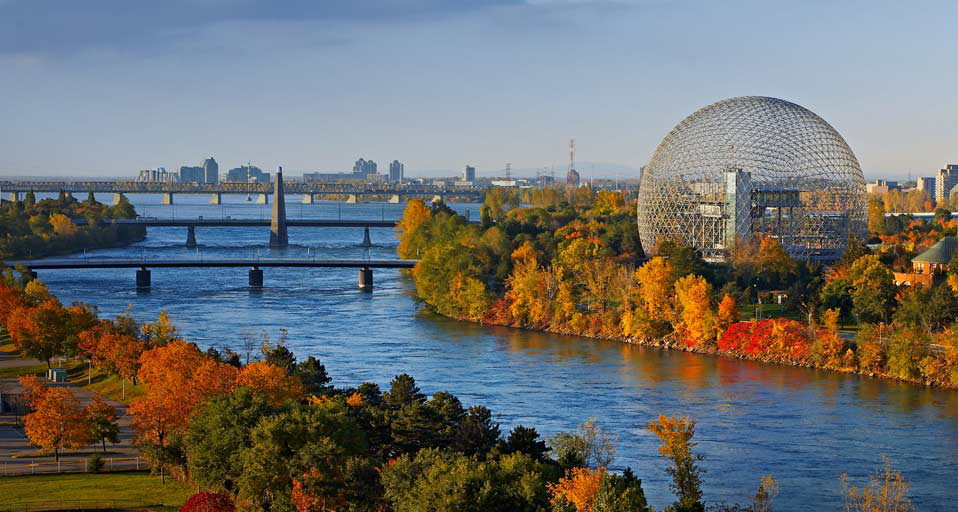

In [2]:
content = Image.open('images/content/biodome.png')
content

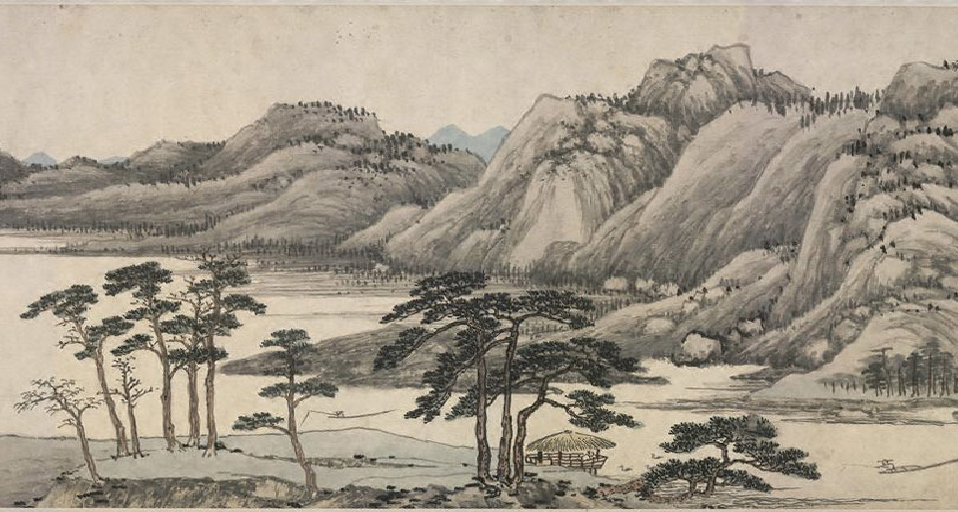

In [3]:
style = Image.open('images/style/fuchun-mountains.png').resize(content.size)
style

# Preprocessing the images

In [4]:
def image_preprocess(img_ar):
    '''
    Input: image as numpy array
    Output: preprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    exp_img_ar = np.expand_dims(np.array(img_ar), 0)
    proc_img_ar = (exp_img_ar - resnet_mean)[:,:,:,::-1]
    return proc_img_ar
#end

def image_postprocess(img_ar, shp):
    '''Input: preprocessed image as numpy array
       Output: postprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    postpr_img_ar = np.clip(img_ar.reshape(shp)[:,:,:,::-1] + resnet_mean, 0, 255)
    return postpr_img_ar
#end

In [5]:
content_array = image_preprocess(content)

In [6]:
style_array = image_preprocess(style)

In [7]:
image_array_shape = content_array.shape

# Defining the losses

## Content Loss

In [8]:
def content_loss(computed, target, weight_ls=None):
    '''
    Input: computed and target tensors (or lists of tensors for more than one content layer)
    Output: content loss calculated as MSE and scaled by the tensor(s) dimension
    '''
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        c_loss = sum([K.sum(metrics.mse(comp[0], targ[0]) * w \
                      for comp, targ, w in zip(computed, target, weight_ls))])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        c_loss = K.sum(metrics.mse(computed, target))
        _, height, width, channels = K.int_shape(computed)
    #end
    c_loss = c_loss #/ (height * width * channels)
    return c_loss

## Style Losses

### Classic style loss

As per Novak and Nikulin, I will be introducing a -1 shift to the gram matrices. The motivation is to limit the sparseness of the Gram matrices.

In [9]:

def gram_matrix(tens):
    features = K.batch_flatten(K.permute_dimensions(tens-1, (2, 0, 1))) # rows = channels, columns = flattened x, y
    gram = K.dot(features, K.transpose(features)) / tens.get_shape().num_elements() #correlate each pair of channels
    return gram
#end

def style_loss(computed, target, weight_ls=None):
    '''
    Input: computed and target tensors (or lists of tensors for more than one style layer)
    Output: content loss calculated as MSE of the Gram matrices and scaled by the tensor(s) dimension
    '''
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        s_loss = sum([K.sum(metrics.mse(gram_matrix(comp[0]), gram_matrix(targ[0]))) * w \
                      for comp, targ, w in zip(computed, target, weight_ls)])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        s_loss = K.sum(metrics.mse(gram_matrix(computed), gram_matrix(target)))
        _, height, width, channels = K.int_shape(computed)
    #end
    s_loss = s_loss #/ (height * width * channels)
    return s_loss

### Spatial Co Occurences Loss

Again, the shift for the above gram matrices will happen again here

In [10]:
def gram_xcc(x, pixel_shift = 4):
    x -= 1
    # First, we want to only take part of the x locations
    x_positive_shift = K.tf.gather(x, K.tf.range(0, x.shape[0]-pixel_shift))
    x_negative_shift = K.tf.gather(x, K.tf.range(pixel_shift, x.shape[0]))
    
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features_positive_shift = K.batch_flatten(K.permute_dimensions(x_positive_shift, (2, 0, 1)))
    features_negative_shift = K.batch_flatten(K.permute_dimensions(x_negative_shift, (2, 0, 1)))
    
    # Now, I want to 'shift' the features tensor, by deleting pixels from opposite sides
    
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features_positive_shift, K.transpose(features_negative_shift)) / x_positive_shift.get_shape().num_elements()

In [11]:
def gram_ycc(x, pixel_shift = 4):
    x -= 1
    x_positive_shift = x[:, pixel_shift:, :]
    x_negative_shift = x[:, :x.shape[1] - pixel_shift, :]
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features_positive_shift = K.batch_flatten(K.permute_dimensions(x_positive_shift, (2, 0, 1)))
    features_negative_shift = K.batch_flatten(K.permute_dimensions(x_negative_shift, (2, 0, 1)))
    
    # Now, I want to 'shift' the features tensor, by deleting pixels from opposite sides
    
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features_positive_shift, K.transpose(features_negative_shift)) / x_positive_shift.get_shape().num_elements()

In [12]:

def cc_loss(computed, target, style_weight_ls):
    if isinstance(computed, list):
        x_loss = sum([K.sum(metrics.mse(gram_xcc(comp[0]), gram_xcc(targ[0])))*w  
                      for comp, targ, w in zip(computed, target, style_weight_ls)])
        y_loss = sum([K.sum(metrics.mse(gram_ycc(comp[0]), gram_ycc(targ[0]))) * w 
                      for comp, targ, w in zip(computed, target, style_weight_ls)])
        s_loss = K.tf.multiply(0.5, K.tf.add(x_loss, y_loss))
    else:
        x_loss = K.sum(metrics.mse(gram_xcc(computed), gram_xcc(target)))
        y_loss = K.sum(metrics.mse(gram_ycc(computed), gram_ycc(target)))
        s_loss = K.tf.multiply(0.5, K.tf.add(x_loss, y_loss))
        #_, height, width, channels = K.int_shape(computed)
    return s_loss

### Histogram Loss

In [13]:
def hist_match(source, template):
    shape = K.tf.shape(source)
    source = K.flatten(source)
    template = K.flatten(template)
    # get the set of unique pixel values and their corresponding indices and
    # counts

    hist_bins = 255

    # Defining the 'x_axis' of the histogram

    max_value = K.tf.reduce_max([K.tf.reduce_max(source), K.tf.reduce_max(template)])
    min_value = K.tf.reduce_min([K.tf.reduce_min(source), K.tf.reduce_min(template)])

    hist_delta = (max_value - min_value)/hist_bins

    # Getting the x-axis for each value
    hist_range = K.tf.range(min_value, max_value, hist_delta)
    # I don't want the bin values; instead, I want the average value of each bin, which is 
    # lower_value + hist_delta/2
    hist_range = K.tf.add(hist_range, K.tf.divide(hist_delta, 2))

    # Now, making fixed width histograms on this hist_axis 

    s_hist = K.tf.histogram_fixed_width(source, 
                                        [min_value, max_value],
                                         nbins = hist_bins, 
                                        dtype = K.tf.int64
                                        )


    t_hist = K.tf.histogram_fixed_width(template, 
                                         [min_value, max_value],
                                         nbins = hist_bins, 
                                        dtype = K.tf.int64
                                        )

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = K.tf.cumsum(s_hist)
    s_last_element = K.tf.subtract(K.tf.size(s_quantiles), K.tf.constant(1))
    s_quantiles = K.tf.divide(s_quantiles, K.tf.gather(s_quantiles, s_last_element))

    t_quantiles = K.tf.cumsum(t_hist)
    t_last_element = K.tf.subtract(K.tf.size(t_quantiles), K.tf.constant(1))
    t_quantiles = K.tf.divide(t_quantiles, K.tf.gather(t_quantiles, t_last_element))


    nearest_indices = K.tf.map_fn(lambda x: K.tf.argmin(K.tf.abs(K.tf.subtract(t_quantiles, x))), 
                                  s_quantiles, dtype = K.tf.int64)

    # Finding the correct s-histogram bin for every element in source
    s_bin_index = K.tf.to_int64(K.tf.divide(source, hist_delta))



    ## In the case where an activation function of 0-1 is used, then there might be some index exception errors. 
    ## This is to deal with those
    s_bin_index = K.tf.clip_by_value(s_bin_index, 0, 254)

    # Matching it to the correct t-histogram bin, and then making it the correct shape again
    matched_to_t = K.tf.gather(hist_range, K.tf.gather(nearest_indices, s_bin_index))
    return K.tf.reshape(matched_to_t, shape)

In [14]:
def hist_loss(calculated, target):
    if isinstance(calculated, list):
        histogram = ([hist_match(calc, targ)
                   for calc,  targ in zip(calculated, target)])
        print ("histogram is " + str(histogram))
        loss = sum([K.sum(metrics.mse(calc,hist))
                   for calc,  hist in zip(calculated, histogram)])
    else: 
        histogram = hist_match(calculated, target)
        loss = K.sum(metrics.mse(calculated,histogram))
    return loss

Defining the total loss

In [15]:
def total_loss(style_layer_ls, style_targ_ls, style_wgt_ls, content_layer, content_targ, style2content_ratio,
               hist_layer_ls, hist_targ_ls, hist_ratio, cc_ratio):
    lr_loss = cc_loss(style_layer_ls, style_targ_ls, style_wgt_ls) / cc_ratio
    s_loss = style_loss(style_layer_ls, style_targ_ls, style_wgt_ls)  
    h_loss = hist_loss(hist_layer_ls, hist_targ_ls) / hist_ratio
    c_loss = content_loss(content_layer, content_targ) / style2content_ratio
    loss = s_loss + h_loss + c_loss 
    return loss
#end

# Getting the targets

In [16]:
def get_content_targets(style_transfer_model, content_ar):
    '''
    Input: style transfer model and numpy array of the content image
    Output: the output of the model at the content layer and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    content_layer = layer_output_dc['block4_conv2'] #change it to another layer of choice if necessary
    content_model = Model(style_transfer_model.input, content_layer)
    content_targ = K.variable(content_model.predict(content_ar))
    return content_layer, content_targ
#end

In [17]:
def get_style_targets(style_transfer_model, style_ar):
    '''Input: style transfer model and numpy array of the style image
       Output: the output of the model at the style layer(s) and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    style_layer_ls = [layer_output_dc['block{}_conv{}'.format(a, b)] for a in range(1,6) for b in range(1,3)] #change it different layers if necessary
    style_model = Model(style_transfer_model.input, style_layer_ls)
    style_targ_ls = [K.variable(o) for o in style_model.predict(style_ar)]
    return style_layer_ls, style_targ_ls
#end

In [22]:
def get_hist_targets(style_transfer_model, style_ar):
    '''Input: style transfer model and numpy array of the style image
       Output: the output of the model at the histogram layers, and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    hist_layer_ls = [layer_output_dc['block{}_conv1'.format(b)] for b in [1, 4]] 
    hist_model = Model(style_transfer_model.input, hist_layer_ls)
    hist_targ_ls = [K.variable(o) for o in hist_model.predict(style_ar)]
    return hist_layer_ls, hist_targ_ls

Defining the evaluator

In [18]:
class Evaluator(object):
    '''
    Initialization: function and shape of the image array
    Returns the loss and the gradients as computed with
       respect to the image that is fed to the CNN
    '''
    def __init__(self, f, shp):
        self.f = f
        self.shp = shp
        return
    #end        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    #end
    def grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)
    #end    
#end

In [19]:
def apply_transfer(eval_obj, n_iter, img, shp, path='./', pref='', save=True, verbose=True):
    '''
    Input: evaluator, number of iterations, input image and shape
    Output: final image, list of losses and info dictionary of optimization procedure
    '''
    info_dc = dict()
    loss_ls = list()
    for it in range(n_iter):
        img, min_val, iter_dc = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                              fprime=eval_obj.grads, maxfun=20, iprint = 1)
        img = np.clip(img, -127, 127)
        info_dc['iteration_'+str(it+1)] = iter_dc
        loss_ls = loss_ls + [min_val]
        if verbose:
            print('Current loss value:', min_val)
        #end
        if save:
            imsave(path + pref + 'res_at_iteration_' + str(it+1) + '.png', image_postprocess(img.copy(), shp)[0])
        #end
    #end
    return img, loss_ls, info_dc
#end

In [20]:
transfer_model = VGG16(pooling = 'Average', include_top =False, input_shape = image_array_shape[1:])

58793984/58889256 [============================>.] - ETA: 0s

In [24]:
content_layer, content_targ = get_content_targets(transfer_model, content_array)
style_layer_ls, style_targ_ls = get_style_targets(transfer_model, style_array)
hist_layer_ls, hist_targ_ls = get_hist_targets(transfer_model, style_array)

InternalError: Dst tensor is not initialized.
	 [[Node: _recv_input_1_0/_157 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_90__recv_input_1_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: block4_conv2/Relu/_159 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_22_block4_conv2/Relu", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]